In [12]:
import os
os.environ["EQX_ON_ERROR"] = 'nan'
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from functools import partial
from jaxdecomp import ShardedArray

from jaxpm.painting import cic_paint_dx
from jaxpm.pm import linear_field, lpt , make_diffrax_ode
from diffrax import (
    ConstantStepSize,
    ODETerm,
    diffeqsolve,
    Dopri5,
    Dopri8,
    Tsit5,
    PIDController,
    RecursiveCheckpointAdjoint,
    BacksolveAdjoint
)

import matplotlib.pyplot as plt
from tqdm import tqdm
from tools.finite_difference import numerical_jvp

jax.config.update("jax_enable_x64", True)

In [13]:
mesh_shape = [64, 64, 64]
box_size = [512.0, 512.0, 512.0]
snapshots = jnp.array([0.2, 0.5, 1.0])

omega_c = 0.25
sigma8 = 0.8
cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(cosmo, k)
pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

# Create initial conditions
initial_conditions = linear_field(
    mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0)
)
initial_conditions = ShardedArray(initial_conditions)

In [14]:
from typing import NamedTuple

class Params(NamedTuple):
    Omega_c : float
    sigma8 : float

@jax.jit
def run_lpt(params, ic):
    cosmo = jc.Planck15(Omega_c=params.Omega_c, sigma8=params.sigma8)
    dx, p, _ = lpt(cosmo, ic, a=0.1, order=1)
    return dx , p

@partial(jax.jit, static_argnums=(2, 3, 4, 5 , 6))
def run_nbody(
    params,
    ic,
    term,
    step_size=0.01,
    stepsize_controller=ConstantStepSize(),
    solver=Tsit5(),
    adjoint=RecursiveCheckpointAdjoint(checkpoints=100)
):
    dx, p = run_lpt(params, ic)
    cosmo = jc.Planck15(Omega_c=params.Omega_c, sigma8=params.sigma8)
    y0 = jax.tree.map(lambda dx , p : jnp.stack([dx, p]) , dx , p)
    # Evolve the simulation forward
    ode_solutions = diffeqsolve(
        term,
        solver=solver,
        t0=0.1,
        t1=1.0,
        dt0=step_size,
        y0=y0,
        args=cosmo,
        stepsize_controller=stepsize_controller,
        adjoint=adjoint,
    )

    return ode_solutions

def MSE(x, y):
    return jnp.mean((x.data - y.data) ** 2)

@jax.jit
def lpt_model(params, ic , obs):
    dx, p = run_lpt(params, ic)
    return MSE(cic_paint_dx(dx), obs) 

@partial(jax.jit, static_argnums=(3, 4 , 5 , 6 , 7))
def model(
    params,
    ic,
    obs,
    term,
    step_size=0.01,
    stepsize_controller=ConstantStepSize(),
    solver=Tsit5(),
    adjoint=RecursiveCheckpointAdjoint(checkpoints=100)
):
    solution = run_nbody(params, ic, term, step_size, stepsize_controller, solver, adjoint)

    if isinstance(term , ODETerm) or len(term) == 1:
        y_hat = solution.ys[-1 , 0]
        y_hat_field = cic_paint_dx(y_hat)
    else:
        y_hat = solution.ys[1][-1]
        y_hat_field = cic_paint_dx(y_hat)

    return MSE(y_hat_field, obs) , solution.stats




nbody = jax.jit(model, static_argnums=(3, 4 , 5 , 6 , 7))

nbody_cosmo = jax.jit(jax.grad(model  , has_aux=True) , static_argnums=(3, 4 , 5 , 6 , 7))   
nbody_ic = jax.jit(jax.grad(model  , argnums=1 , has_aux=True) , static_argnums=(3, 4 , 5 , 6 , 7))

lpt_cosmo = jax.jit(jax.grad(lpt_model))
lpt_ic = jax.jit(jax.grad(lpt_model , argnums=1))

In [15]:
params = Params(0.25, 0.8)

stepsize_controller = PIDController(rtol=1e-6, atol=1e-6)
ode_term = ODETerm(make_diffrax_ode(mesh_shape, paint_absolute_pos=False))
obs_solution = run_nbody(
    params,
    initial_conditions,
    ode_term,
    stepsize_controller=stepsize_controller,
    solver=Tsit5(),
)
lpt_dx , _ = run_lpt(params, initial_conditions)

observable = cic_paint_dx(obs_solution.ys[-1, 0])
lpt_observation = cic_paint_dx(lpt_dx)

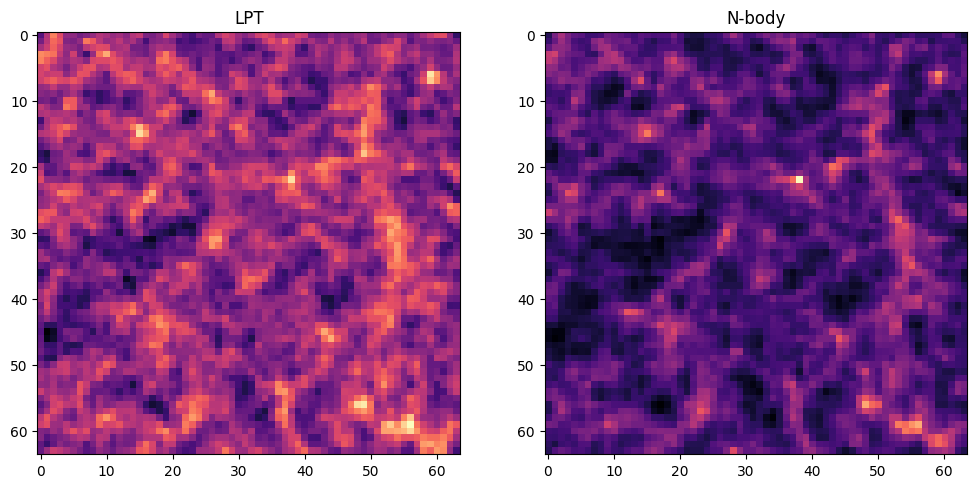

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(lpt_observation[10:].sum(axis=0).data , cmap="magma")
plt.title("LPT")
plt.subplot(122)
plt.imshow(observable[10:].sum(axis=0).data , cmap="magma")
plt.title("N-body")
plt.show()

In [17]:
best_params = params
guess_params = Params(Omega_c=0.8, sigma8=0.8)


best_grad  , _ = nbody_cosmo(best_params,  initial_conditions , observable, ode_term, stepsize_controller=stepsize_controller, solver=Tsit5())
guess_grad   , _ = nbody_cosmo(guess_params, initial_conditions ,  observable, ode_term, stepsize_controller=stepsize_controller, solver=Tsit5())

print(f"Gradient at the correct cosmology: {best_grad}")
print(f"Evaluating the gradient at the Correct Cosmology: {guess_grad}")

Gradient at the correct cosmology: Params(Omega_c=Array(-7.15130715e-16, dtype=float64, weak_type=True), sigma8=Array(0., dtype=float64, weak_type=True))
Evaluating the gradient at the Correct Cosmology: Params(Omega_c=Array(0.00204948, dtype=float64, weak_type=True), sigma8=Array(0., dtype=float64, weak_type=True))


In [18]:
best_ic = initial_conditions

cosmo = jc.Planck15(Omega_c=best_params.Omega_c, sigma8=best_params.sigma8)
pk = jc.power.linear_matter_power(cosmo, k)
pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

# Create initial conditions
guess_ic = linear_field(
    mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(42)
)
guess_ic = ShardedArray(guess_ic)


best_grad  , _ = nbody_ic(best_params,  best_ic , observable, ode_term, stepsize_controller=stepsize_controller, solver=Tsit5())
guess_grad   , _ = nbody_ic(best_params, guess_ic ,  observable, ode_term, stepsize_controller=stepsize_controller, solver=Tsit5())

print(f"Gradient at the correct cosmology: Max {best_grad.max()} min {best_grad.min()}")
print(f"Evaluating the gradient at the Correct Cosmology: Max {guess_grad.max()} min {guess_grad.min()}")

Gradient at the correct cosmology: Max ShardedArray(data=1.683098878418543e-17, sharding=None) min ShardedArray(data=-1.4225174129952074e-17, sharding=None)
Evaluating the gradient at the Correct Cosmology: Max ShardedArray(data=0.00025310943276845687, sharding=None) min ShardedArray(data=-4.066735028479296e-05, sharding=None)


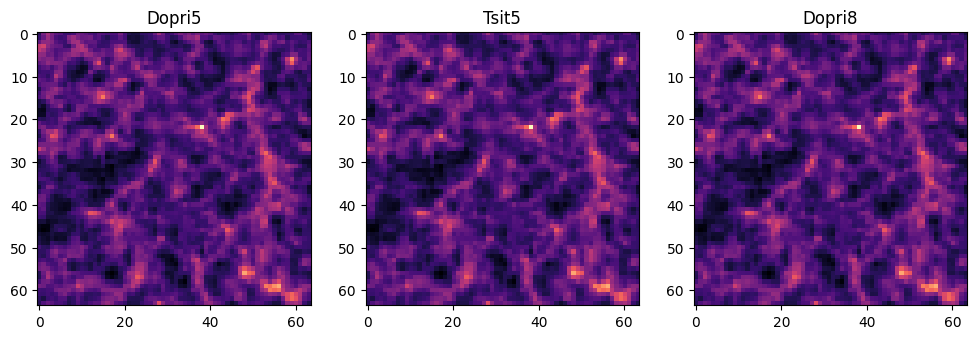

In [19]:
stepsize_controller = PIDController(rtol=1e-9, atol=1e-9)
ode_term = ODETerm(make_diffrax_ode(mesh_shape, paint_absolute_pos=False))
ode_solutions_dopri = run_nbody(
    best_params,
    best_ic,
    ode_term,
    stepsize_controller=stepsize_controller,
    solver=Dopri5(),
)
dopri_field = cic_paint_dx(ode_solutions_dopri.ys[-1, 0])

stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)
ode_solutions_tsit = run_nbody(
    best_params,
    best_ic,
    ode_term,
    stepsize_controller=stepsize_controller,
    solver=Tsit5(),
)
tsit_field = cic_paint_dx(ode_solutions_tsit.ys[-1, 0])

stepsize_controller = PIDController(rtol=1e-6, atol=1e-6)
ode_solutions_dopri8 = run_nbody(
    best_params,
    best_ic,
    ode_term,
    stepsize_controller=stepsize_controller,
    solver=Dopri8(),
)
dopri8_field = cic_paint_dx(ode_solutions_dopri8.ys[-1, 0])

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(dopri_field[10:].sum(axis=0).data , cmap="magma")
plt.title("Dopri5")
plt.subplot(132)
plt.imshow(tsit_field[10:].sum(axis=0).data , cmap="magma")
plt.title("Tsit5")
plt.subplot(133)
plt.imshow(dopri8_field[10:].sum(axis=0).data , cmap="magma")
plt.title("Dopri8")
plt.show()

In [20]:
import jax
import jax.numpy as jnp
from equinox.internal import while_loop

# Input array
a = jnp.linspace(0.1, 1.0, 128)

# Function with checkpointing
def fn_checkpointed(a):
    def cond_fn(state):
        i, _ = state
        return i < len(a)

    def body_fn(state):
        i, carry = state
        carry = carry + a[i]  # Update carry
        return i + 1, carry  # Increment index

    # Initialize the loop
    init_state = (0, 0.0)  # (index, carry)
    return while_loop(
        cond_fn,
        body_fn,
        init_state,
        kind="checkpointed",  # Use checkpointing
        max_steps=len(a),  # Optional for bounded while loops
        checkpoints=len(a),  # Only 1 checkpoint to save memory
    )[1]  # Return the carry

# Function without checkpointing
def fn_standard(a):
    def cond_fn(state):
        i, _ = state
        return i < len(a)

    def body_fn(state):
        i, carry = state
        carry = carry + a[i]  # Update carry
        return i + 1, carry  # Increment index

    # Initialize the loop
    init_state = (0, 0.0)  # (index, carry)
    return while_loop(
        cond_fn,
        body_fn,
        init_state,
        kind="checkpointed",  # Use checkpointing
        max_steps=len(a),  # Optional for bounded while loops
        checkpoints=200,  # Only 1 checkpoint to save memory
    )[1]  # Return the carry

# Compile both functions and analyze memory usage
m_checkpointed = jax.jit(jax.grad(fn_checkpointed)).lower(a).compile().memory_analysis()
m_standard = jax.jit(jax.grad(fn_standard)).lower(a).compile().memory_analysis()

# Print memory usage
print(f"With checkpointing: {m_checkpointed.temp_size_in_bytes / 1024} KB")
print(f"Without checkpointing: {m_standard.temp_size_in_bytes / 1024} KB")


With checkpointing: 1.7509765625 KB
Without checkpointing: 1.7509765625 KB


In [21]:
TSIT_BASE_RTOL = 4e-9
DOPRI_BASE_RTOL = 1e-9

In [22]:
ode_term = ODETerm(make_diffrax_ode(mesh_shape, paint_absolute_pos=False))

def adaptive_steps_model(solver ,observable , adjoint , rtol):
    atol = rtol
    stepsize_controller = PIDController(rtol=rtol, atol=atol)
    if adjoint == "finite_diff":
        def fn(guess_params):
            val , _ = nbody(guess_params, guess_ic , observable, ode_term, stepsize_controller=stepsize_controller, solver=solver)
            return val
        
        tangents = Params(jnp.array(1.0) , jnp.array(0.0))
        grads  = numerical_jvp(fn, (guess_params,) , (tangents,) , eps=1e-12)
        return grads , 0
        
    grads , stats =  nbody_cosmo(guess_params, guess_ic , observable, ode_term, stepsize_controller=stepsize_controller, solver=solver,adjoint=adjoint)
    return grads.Omega_c , stats["num_steps"]

def generate_gradient_data(solver , observable , adjoint , base_line_tol=1e-6):
    gradients , steps , tols = [] , [] , []
    print(f"running for {solver} with adjoint {adjoint} with base line tol {base_line_tol}")
    for rtol in tqdm(jnp.logspace( -2 , jnp.log10(base_line_tol* 2) , 8 , endpoint=True).tolist()):
        grad , num_steps = adaptive_steps_model(solver ,observable ,  adjoint , rtol)
        gradients.append(grad)
        steps.append(num_steps)
        tols.append(rtol)
    
    return gradients , steps , tols



base_tsit_grad , base_tsit_steps = adaptive_steps_model(Tsit5() , tsit_field , RecursiveCheckpointAdjoint(checkpoints=100) , rtol = TSIT_BASE_RTOL)
base_dopri_grad , base_dopri_steps = adaptive_steps_model(Dopri5() , dopri_field , RecursiveCheckpointAdjoint(checkpoints=100) , rtol =DOPRI_BASE_RTOL)

tsit_grads_DTO , tsit_steps_DTO, tols = generate_gradient_data(Tsit5() , tsit_field , RecursiveCheckpointAdjoint(checkpoints=100)  , base_line_tol=TSIT_BASE_RTOL)
tsit_grads_OTD , tsit_steps_OTD , tols= generate_gradient_data(Tsit5() , tsit_field , BacksolveAdjoint(solver=Tsit5())  , base_line_tol= TSIT_BASE_RTOL)
tsit_grads_fd , _ , tols = generate_gradient_data(Tsit5() , tsit_field , "finite_diff"  , base_line_tol=TSIT_BASE_RTOL)

dopri_grads_DTO , dopri_steps_DTO , tols = generate_gradient_data(Dopri5() , dopri_field , RecursiveCheckpointAdjoint(checkpoints=100) , base_line_tol=DOPRI_BASE_RTOL)
dopri_grads_OTD , dopri_steps_OTD , tols = generate_gradient_data(Dopri5() , dopri_field , BacksolveAdjoint(solver=Dopri5()), base_line_tol=DOPRI_BASE_RTOL)
dopri_grads_fd , _ , tols = generate_gradient_data(Dopri5() , dopri_field , "finite_diff" , base_line_tol=DOPRI_BASE_RTOL)


running for Tsit5(scan_kind=None) with adjoint RecursiveCheckpointAdjoint(checkpoints=100) with base line tol 4e-09


100%|██████████| 8/8 [02:13<00:00, 16.70s/it]


running for Tsit5(scan_kind=None) with adjoint BacksolveAdjoint(kwargs={'solver': Tsit5(scan_kind=None)}) with base line tol 4e-09


100%|██████████| 8/8 [01:50<00:00, 13.84s/it]


running for Tsit5(scan_kind=None) with adjoint finite_diff with base line tol 4e-09


100%|██████████| 8/8 [00:44<00:00,  5.51s/it]


running for Dopri5(scan_kind=None) with adjoint RecursiveCheckpointAdjoint(checkpoints=100) with base line tol 1e-09


100%|██████████| 8/8 [02:16<00:00, 17.01s/it]


running for Dopri5(scan_kind=None) with adjoint BacksolveAdjoint(kwargs={'solver': Dopri5(scan_kind=None)}) with base line tol 1e-09


100%|██████████| 8/8 [01:56<00:00, 14.54s/it]


running for Dopri5(scan_kind=None) with adjoint finite_diff with base line tol 1e-09


100%|██████████| 8/8 [00:43<00:00,  5.44s/it]


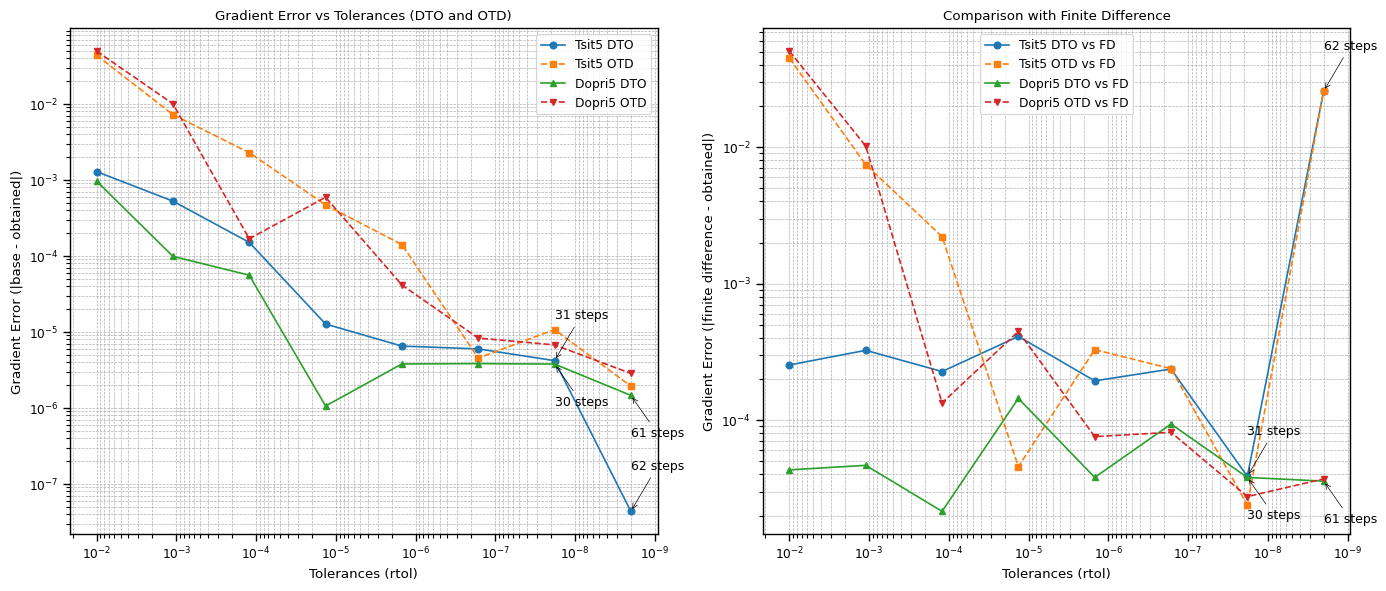

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("paper")

# Compute absolute errors
tsit_error_DTO = [abs(base_tsit_grad - grad) for grad in tsit_grads_DTO]
tsit_error_OTD = [abs(base_tsit_grad - grad) for grad in tsit_grads_OTD]
dopri_error_DTO = [abs(base_dopri_grad - grad) for grad in dopri_grads_DTO]
dopri_error_OTD = [abs(base_dopri_grad - grad) for grad in dopri_grads_OTD]

# Compute errors relative to finite differences
tsit_error_FD_DTO = [abs(fd_grad - dto_grad) for fd_grad, dto_grad in zip(tsit_grads_fd, tsit_grads_DTO)]
tsit_error_FD_OTD = [abs(fd_grad - otd_grad) for fd_grad, otd_grad in zip(tsit_grads_fd, tsit_grads_OTD)]
dopri_error_FD_DTO = [abs(fd_grad - dto_grad) for fd_grad, dto_grad in zip(dopri_grads_fd, dopri_grads_DTO)]
dopri_error_FD_OTD = [abs(fd_grad - otd_grad) for fd_grad, otd_grad in zip(dopri_grads_fd, dopri_grads_OTD)]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Gradient Error vs Tolerance (DTO and OTD) in Subplot 1
ax1.plot(tols, tsit_error_DTO, marker="o", linestyle="-", label="Tsit5 DTO")
ax1.plot(tols, tsit_error_OTD, marker="s", linestyle="--", label="Tsit5 OTD")
ax1.plot(tols, dopri_error_DTO, marker="^", linestyle="-", label="Dopri5 DTO")
ax1.plot(tols, dopri_error_OTD, marker="v", linestyle="--", label="Dopri5 OTD")

# Annotate the last two points for each solver/mode
for solver, errors, steps, marker, offset in [
    ("Tsit5 DTO", tsit_error_DTO, tsit_steps_DTO, "o", (0, 30)),
    ("Dopri5 DTO", dopri_error_DTO, dopri_steps_DTO, "^", (0, -30)),
]:
    for i in range(-2, 0):  # Annotate the last two points
        ax1.annotate(f"{steps[i]} steps", 
                     (tols[i], errors[i]), 
                     textcoords="offset points", 
                     xytext=(offset[0], offset[1]),  # Adjust offsets to avoid overlap
                     fontsize=9, 
                     arrowprops=dict(arrowstyle="->", color="black", lw=0.5))

# Customize Subplot 1
ax1.set_xscale("log")  # Log scale for tolerances
ax1.set_yscale("log")  # Log scale for gradient errors
ax1.invert_xaxis()  # Reverse the X-axis
ax1.set_xlabel("Tolerances (rtol)")
ax1.set_ylabel("Gradient Error (|base - obtained|)")
ax1.set_title("Gradient Error vs Tolerances (DTO and OTD)")
ax1.legend()
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Plot Finite Difference Comparison in Subplot 2
ax2.plot(tols, tsit_error_FD_DTO, marker="o", linestyle="-", label="Tsit5 DTO vs FD")
ax2.plot(tols, tsit_error_FD_OTD, marker="s", linestyle="--", label="Tsit5 OTD vs FD")
ax2.plot(tols, dopri_error_FD_DTO, marker="^", linestyle="-", label="Dopri5 DTO vs FD")
ax2.plot(tols, dopri_error_FD_OTD, marker="v", linestyle="--", label="Dopri5 OTD vs FD")

# Annotate the last two points for each solver/mode in Subplot 2
for solver, errors, steps, marker, offset in [
    ("Tsit5 DTO vs FD", tsit_error_FD_DTO, tsit_steps_DTO, "o", (0, 30)),
    ("Dopri5 DTO vs FD", dopri_error_FD_DTO, dopri_steps_DTO, "^", (0, -30)),
]:
    for i in range(-2, 0):  # Annotate the last two points
        ax2.annotate(f"{steps[i]} steps", 
                     (tols[i], errors[i]), 
                     textcoords="offset points", 
                     xytext=(offset[0], offset[1]),  # Adjust offsets to avoid overlap
                     fontsize=9, 
                     arrowprops=dict(arrowstyle="->", color="black", lw=0.5))

# Customize Subplot 2
ax2.set_xscale("log")  # Log scale for tolerances
ax2.set_yscale("log")  # Log scale for gradient errors
ax2.invert_xaxis()  # Reverse the X-axis
ax2.set_xlabel("Tolerances (rtol)")
ax2.set_ylabel("Gradient Error (|finite difference - obtained|)")
ax2.set_title("Comparison with Finite Difference")
ax2.legend()
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)

# Adjust layout and save
plt.tight_layout()
plt.savefig("gradient_error_comparison_no_overlap.pdf", dpi=600, transparent=True)
plt.show()


In [24]:
def adaptive_steps_memory(solver ,observable , adjoint , rtol):
    atol = rtol
    stepsize_controller = PIDController(rtol=rtol, atol=atol)
    @jax.jit
    def fn(guess_params):
        return  nbody_cosmo(guess_params, guess_ic , observable, ode_term, stepsize_controller=stepsize_controller, solver=solver,adjoint=adjoint)

    grad , steps = fn(guess_params) 
    memory =  fn.lower(guess_params).compile().memory_analysis().temp_size_in_bytes 
    return grad.Omega_c , steps['num_steps'] , memory


def generate_memory_data(solver , observable , base_line_tol=1e-6):
    gradients , steps , checkpoints  , memories = [] , [] , [] , []
    for checkpoint in tqdm(jnp.arange(20 , 90 , 10).tolist()):
        adjoint = RecursiveCheckpointAdjoint(checkpoints=checkpoint)
        grad , num_steps , memory  = adaptive_steps_memory(solver ,observable ,  adjoint , base_line_tol)
        gradients.append(grad)
        steps.append(num_steps)
        checkpoints.append(checkpoint)
        memories.append(memory)
    
    return gradients , steps , checkpoints , memories


tsit_grad_base_OTD , tsit_steps_base_OTD , tsit_memory_base_OTD = adaptive_steps_memory(Tsit5() , tsit_field , BacksolveAdjoint(solver=Tsit5()) , rtol = TSIT_BASE_RTOL)
dopri_grad_base_OTD , dopri_steps_base_OTD , dopri_memory_base_OTD = adaptive_steps_memory(Dopri5() , dopri_field , BacksolveAdjoint(solver=Dopri5()) , rtol = DOPRI_BASE_RTOL)

tsit_grad_base_DTO , tsit_steps_base_DTO , tsit_memory_base_DTO = adaptive_steps_memory(Tsit5() , tsit_field , RecursiveCheckpointAdjoint(checkpoints=100) , rtol = TSIT_BASE_RTOL)
dopri_grad_base_DTO , dopri_steps_base_DTO , dopri_memory_base_DTO = adaptive_steps_memory(Dopri5() , dopri_field , RecursiveCheckpointAdjoint(checkpoints=100) , rtol = DOPRI_BASE_RTOL)

tsit_grads_DTO , tsit_steps_DTO , tsit_checkpoints_DTO , tsit_memories_DTO = generate_memory_data(Tsit5() , tsit_field , base_line_tol=TSIT_BASE_RTOL)
dopri_grads_DTO , dopri_steps_DTO , dopri_checkpoints_DTO , dopri_memories_DTO = generate_memory_data(Dopri5() , dopri_field , base_line_tol=DOPRI_BASE_RTOL)

100%|██████████| 7/7 [04:24<00:00, 37.74s/it]


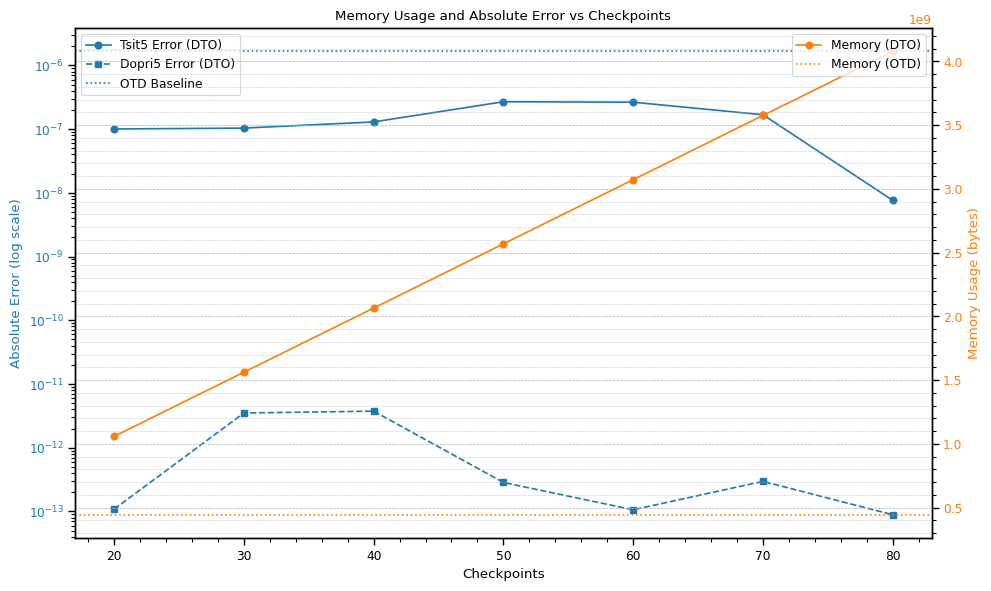

In [ ]:
# Data Preparation
checkpoints = dopri_checkpoints_DTO

# Error baselines
tsit_grad_base_OTD_err = abs(tsit_grad_base_OTD - dopri_grad_base_OTD)  # Baseline absolute error for OTD
dopri_grad_base_OTD_err = abs(dopri_grad_base_OTD - dopri_grad_base_OTD)  # Baseline absolute error for OTD

# Errors for DTO and OTD
tsit_error_DTO = [abs(tsit_grad_base_DTO - grad) for grad in tsit_grads_DTO]
dopri_error_DTO = [abs(dopri_grad_base_DTO - grad) for grad in dopri_grads_DTO]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define colors
error_color = "tab:blue"
memory_color = "tab:orange"

# Primary Y-axis: Absolute Error
ax1.set_xlabel('Checkpoints')
ax1.set_ylabel('Absolute Error (log scale)', color=error_color)

# Plot errors
ax1.plot(checkpoints, tsit_error_DTO, marker='o', color=error_color, label="Tsit5 Error (DTO)")
ax1.plot(checkpoints, dopri_error_DTO, marker='s', color=error_color, linestyle='--', label="Dopri5 Error (DTO)")

# Add horizontal line for baseline errors
ax1.axhline(tsit_grad_base_OTD_err, color=error_color, linestyle=':', label="OTD Baseline")

ax1.tick_params(axis='y', labelcolor=error_color)
ax1.set_yscale("log")  # Log scale for absolute error
ax1.legend(loc='upper left')

# Secondary Y-axis: Memory Usage
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.set_ylabel('Memory Usage (bytes)', color=memory_color)

# Plot memory usage
ax2.plot(checkpoints, tsit_memories_DTO, marker='o', linestyle='-', color=memory_color, label="Memory (DTO)")

# Add horizontal line for memory baselines
ax2.axhline(tsit_memory_base_OTD, color=memory_color, linestyle=':', label="Memory (OTD)")

ax2.tick_params(axis='y', labelcolor=memory_color)
ax2.legend(loc='upper right')

# Title and grid
plt.title("Memory Usage and Absolute Error vs Checkpoints")
plt.grid(which='both', linestyle='--', linewidth=0.5)  # Add x-y grid
plt.minorticks_on()  # Enable minor ticks for finer grid
plt.grid(which='minor', linestyle=':', linewidth=0.5)  # Minor grid lines

# Show or Save
plt.tight_layout()
plt.show()


In [45]:
tsit_memories_DTO_m

[1010.0932769775391,
 1490.0933990478516,
 1970.095230102539,
 2450.096939086914,
 2930.096939086914,
 3410.098892211914,
 3890.098892211914]

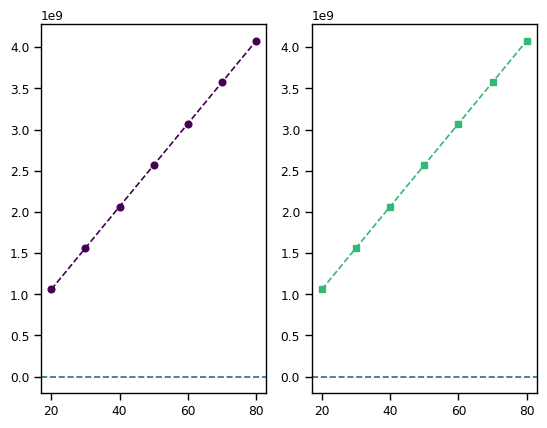

In [68]:
plt.subplot(121)
plt.plot(checkpoints, tsit_memories_DTO, marker='o', linestyle='--', color=color_cycle[0], label="Tsit5 OTD (Memory)")
plt.axhline(tsit_grad_base_OTD_err, color=color_cycle[1], linestyle='--', label="Tsit5 OTD Baseline")
plt.subplot(122)
plt.plot(checkpoints, dopri_memories_DTO, marker='s', linestyle='--', color=color_cycle[2], label="Dopri5 OTD (Memory)")
plt.axhline(dopri_grad_base_OTD_err, color=color_cycle[1], linestyle='--', label="Dopri OTD Baseline")